In [30]:
#Run these beforehand
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)

# Data Description
The dataset is separated into two lists. One is a list of 196 unique players with 7 variables of data on each player:
- experience, their experience as one of 'Beginner', 'Regular', 'Amateur', 'Veteran', or 'Pro' (chr)
- hashedEmail, Private hashed email address (chr)
- name, player name (chr)
- gender, player gender (chr)
- played_hours, number of hours they have played on the server (dbl)
- Age, player age in years (dbl)
- subscribe, whether or not they are subscribed to a games-related news letter (lgl)

Means of quantitative variables:
| played_hours | Age |
| --- | --- |
| 5.85 | 21.14|

Some issues I noticed with this list was that experience hierarchy is unclear (such as wehther or not 'Regular' is more experienced than 'Amatuer', how is the experience determined, etc), there are NA values in the age, and that it is unclear which news letter the players are subscribed to.

The other is a list of individual play sessions with 5 variables on each session:
- hashedEmail, private hashed email address (chr)
- start_time, start time of session in day/month/year time (chr)
- end_time, end time of session in day/month/year time (chr)
- original_start_time, Unix epoch start time in milliseconds (dbl)
- original_end_time, Unix epoch end time in milliseconds (dbl)

Some issues I noticed with this list is that the start and end include the time and date in the same column, and should probably be seperated. It also lacks the session time length, which is probably the most basic piece of data which should be included as it's own column. I am also not certain if every session is associated with a hashedEmail in the player list. 

# Questions
For this project I would like to focus on Question 2, or what "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts. The specific question I would like to ask is: Can player experience and and age predict the length of play time in the list of sessions for that player. To answer this question, I would use the data to determine if age and total session length have a linear assocation. I could also either split the data by the categories of experience, or use k-nn fit algorithms to see which creates a better prediction system. Since there are NA values in the age, I would likely have to remove those observations in the cases when examining age, and I would also likely need to create a new session length column in the list of sessions for ease of use. 

# Exploratory Data Analysis

In [3]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [31]:
clean_sessions <- separate(sessions, start_time, c("start_date", "start_time"), " ") |>
    separate(end_time, c("end_date", "end_time"), " ")
colnames(clean_sessions) <- c("hashed_email", "start_date", "start_time", "end_date", "end_time", "original_start_time", "original_end_time")
clean_sessions <- mutate(clean_sessions, "session_length" = (original_end_time - original_start_time)/3600000)
colnames(players) <- c("experience","subscribe", "hashed_email", "played_hours", "name", "gender", "age")
#head(clean_sessions)
#head(players)

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”


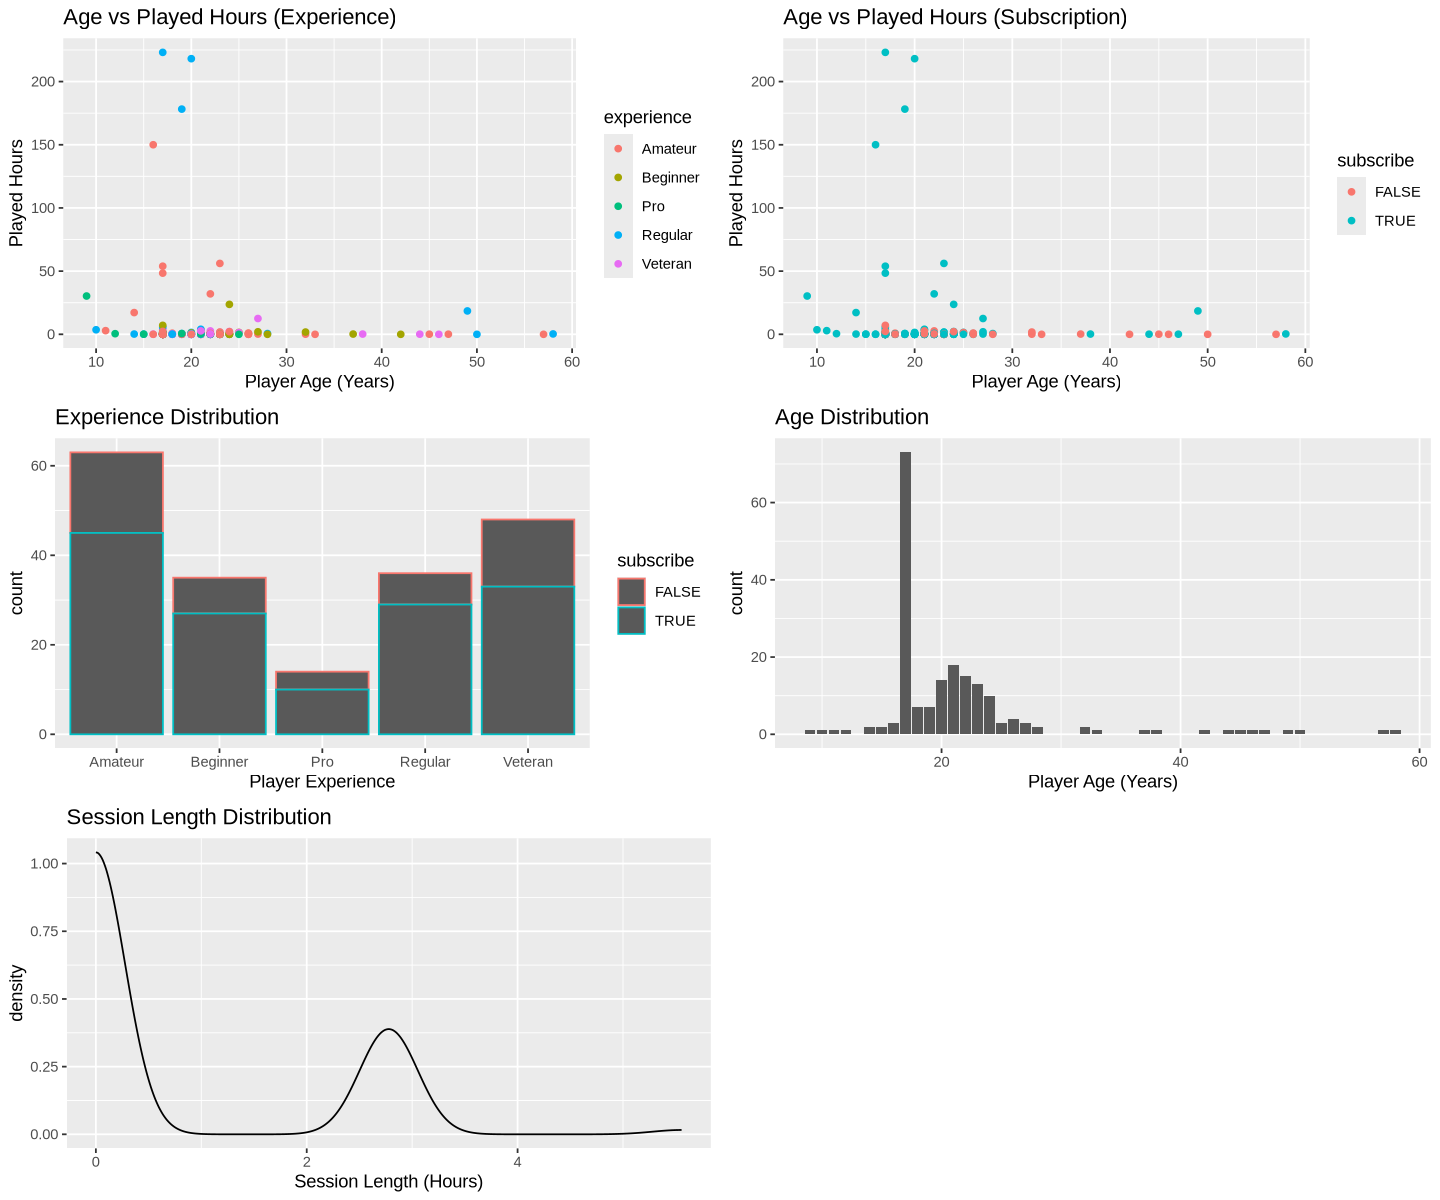

In [34]:
options(repr.plot.width = 12, repr.plot.height = 10) 
played_plot <- players |>
    ggplot(aes(x = age, y =  played_hours, colour = experience)) + 
        geom_point() +
        xlab("Player Age (Years)") +
        ylab("Played Hours") +
        ggtitle("Age vs Played Hours (Experience)")

subscribe_plot <- players |>
    ggplot(aes(x = age, y =  played_hours, colour = subscribe)) + 
        geom_point() +
        xlab("Player Age (Years)") +
        ylab("Played Hours") +
        ggtitle("Age vs Played Hours (Subscription)")

experience_plot <- players |>
    ggplot(aes(x = experience, colour = subscribe)) + 
    geom_bar() + 
    xlab("Player Experience") + 
    ggtitle("Experience Distribution")

age_plot <- players |>
    ggplot(aes(x = age)) + 
    geom_bar() + 
    xlab("Player Age (Years)") + 
    ggtitle("Age Distribution")

length_plot <- clean_sessions |>
    ggplot(aes(x = session_length)) + 
    geom_density() + 
    xlab("Session Length (Hours)") + 
    ggtitle("Session Length Distribution")

grid.arrange(played_plot, subscribe_plot, experience_plot, age_plot, length_plot, ncol = 2)

Session length seems to be on average very short, but that does not give us any hints towards what the total session length would be for each unique player or hashed email. There does seem to be some suggestions that players around the age of 20 who range along the amateur to regular experience levels have the most played hours, which will be useful to look out for in the future. These players also fortunately seem to be the most common. Subscribed players also seem to have the highest played hours, and also seem more common than unsubscribed players. 

# Methods and Plan

To answer this question I propose that k-nn regression to predict the total session playtime using player age and experience. This method is appropriate because we can turn player experience into quantitative variables using the natural ascending order, and it is unlikely from our initial exploration that there will be a linear association between the explanatory and response variables. There are also very little assumptions required, which makes this method easy to apply here. It is possible that as we increase training data the algorithm may slow down, and may not be applicable outside the range of our explanatory variables. But I believe that amount of observations is not too high, and our explanatory variables have natural boundaries (lifespan and preset categories) that prevent us from having to predict outside of our range. We will use RMPSE to optimize the number of neighbours (K) with cross validation by splitting the data into testing and training subsets. Training 